# Comparación Completa de Todos los Modelos

Este notebook compara todos los modelos entrenados y selecciona el mejor para producción:

**Modelos Baseline (Notebook 04):**
- Persistencia (1 día y 7 días)
- Media Móvil
- Regresión Lineal

**Modelos Basados en Árboles - Manual (Notebook 05):**
- Random Forest (hiperparámetros por defecto)
- XGBoost (hiperparámetros por defecto)
- LightGBM (hiperparámetros por defecto)
- CatBoost (hiperparámetros por defecto)

**Modelos Basados en Árboles - Optimizados con Optuna (Notebook 06):**
- Random Forest (Optuna)
- XGBoost (Optuna)
- LightGBM (Optuna)
- CatBoost (Optuna)

**Redes Neuronales (Notebook 07):**
- MLP Mejorado (arquitectura simplificada)
- LSTM Mejorado (secuencias 168h)
- CNN-LSTM Mejorado (arquitectura profunda)

**Objetivo**: Identificar el modelo con mejor balance precisión/velocidad para desplegar en producción.

In [15]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
import joblib

# Métricas de evaluación
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

# Configuración
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [16, 8]

## Cargar Resultados de Modelos Baseline

Vamos a recopilar los resultados del notebook 04 (baseline models).

In [16]:
# Cargar resultados de modelos baseline
baseline_results_path = Path('artifacts/trained_models/baseline_models_results.csv')

if baseline_results_path.exists():
    baseline_df = pd.read_csv(baseline_results_path)
    baseline_df['tipo'] = 'baseline'
    print("Resultados de Modelos Baseline (Notebook 04):")
    display(baseline_df)
else:
    print("No se encontraron resultados de modelos baseline.")
    print("Ejecuta primero el notebook 04_baseline_models.ipynb")
    baseline_df = pd.DataFrame()

Resultados de Modelos Baseline (Notebook 04):


,modelo,mae,rmse,mape,r2,tiempo_entrenamiento,tipo
0,Persistencia 1d,1667.909,2505.337,5.605,0.569,0.100,baseline
1,Persistencia 7d,1552.620,2008.287,5.164,0.723,0.100,baseline
2,Media Móvil (72h),1398.714,1839.190,4.732,0.768,0.500,baseline
3,Regresión Lineal,1448.770,1980.143,4.805,0.731,2.000,baseline


## Cargar Resultados de Modelos Basados en Árboles

In [17]:
# Cargar resultados de modelos de árboles
tree_results_path = Path('artifacts/trained_models/tree_models_results.csv')

if tree_results_path.exists():
    tree_df = pd.read_csv(tree_results_path)
    tree_df['tipo'] = 'tree_based'
    print("Resultados de Modelos Basados en Árboles:")
    display(tree_df)
else:
    print("No se encontraron resultados de modelos basados en árboles.")
    print("Ejecuta primero el notebook 05_advanced_models_tree_based.ipynb")
    tree_df = pd.DataFrame()

Resultados de Modelos Basados en Árboles:


,modelo,mae,rmse,mape,r2,tiempo_entrenamiento,tipo
0,Random Forest (Test),343.638,461.932,1.144,0.985,0.654,tree_based
1,XGBoost (Test),217.835,290.080,0.725,0.994,0.643,tree_based
2,LightGBM (Test),259.779,339.541,0.870,0.992,1.057,tree_based
3,CatBoost (Test),264.402,334.966,0.885,0.992,0.609,tree_based


## Cargar Resultados de Redes Neuronales Mejoradas

Cargamos los resultados del notebook 07 (versión mejorada con optimizaciones).

In [18]:
# Cargar resultados de redes neuronales (notebook 07)
neural_results_path = Path('artifacts/trained_models/neural_models_results.csv')

if neural_results_path.exists():
    neural_df = pd.read_csv(neural_results_path)
    neural_df['tipo'] = 'neural_network'
    print("Resultados de Redes Neuronales (Notebook 07):")
    display(neural_df)
    
else:
    print("No se encontraron resultados de redes neuronales.")
    print("Ejecuta primero el notebook 07_models_neural_networks.ipynb")
    neural_df = pd.DataFrame()

Resultados de Redes Neuronales (Notebook 07):


,modelo,mae,rmse,mape,r2,tiempo_entrenamiento,tipo
0,MLP (Test),271.207,352.156,0.900,0.991,25.722,neural_network
1,LSTM (Test),406.484,519.873,1.353,0.981,173.606,neural_network
2,CNN-LSTM (Test),304.683,397.018,1.031,0.989,142.990,neural_network


## Cargar Resultados de Optimización con Optuna (Notebook 06)

Si se ejecutó el notebook 06 de optimización, cargamos los resultados de TODOS los modelos optimizados con Optuna.

In [19]:
# Cargar resultados de optimización con Optuna (notebook 06)
optuna_results_path = Path('artifacts/optuna/optimization_results.csv')

if optuna_results_path.exists():
    # Cargar CSV con resultados de cross-validation de los 4 modelos
    optuna_df = pd.read_csv(optuna_results_path)
    
    # Renombrar columna mae_cv a mae para consistencia
    optuna_df = optuna_df.rename(columns={'mae_cv': 'mae'})
    
    # Añadir tipo y calcular métricas faltantes (aproximadas desde MAE)
    optuna_df['tipo'] = 'tree_based_optuna'
    
    # Aproximar otras métricas (asumiendo relaciones típicas)
    # RMSE ≈ MAE * 1.3, MAPE ≈ (MAE/demanda_media)*100, R² se calculará después
    demanda_media = 29570  # MW aproximado
    optuna_df['rmse'] = optuna_df['mae'] * 1.3
    optuna_df['mape'] = (optuna_df['mae'] / demanda_media) * 100
    optuna_df['r2'] = 0.99  # Placeholder - será actualizado con métricas reales
    
    # Tiempo de entrenamiento: valor pequeño para visualización (no disponible en el archivo)
    # Usamos 0.5s como placeholder para que aparezca en gráficos con escala log
    optuna_df['tiempo_entrenamiento'] = 0.5
    
    print("Resultados de Optimización con Optuna (Notebook 06 - 4 modelos):")
    print(f"\nSe cargaron {len(optuna_df)} modelos optimizados con Optuna")
    display(optuna_df[['modelo', 'mae', 'rmse', 'mape', 'n_trials']])
    
    # Intentar cargar métricas detalladas del mejor modelo si existen
    optuna_metrics_path = Path('artifacts/optuna/validation_metrics.json')
    if optuna_metrics_path.exists():
        import json
        with open(optuna_metrics_path, 'r') as f:
            optuna_best_data = json.load(f)
        
        print(f"\nMejor modelo Optuna (métricas detalladas en validación):")
        print(f"  Modelo: {optuna_best_data['modelo']}")
        print(f"  MAE Validation: {optuna_best_data['metricas_validacion']['mae']:,.2f} MW")
        print(f"  RMSE Validation: {optuna_best_data['metricas_validacion']['rmse']:,.2f} MW")
        print(f"  MAPE Validation: {optuna_best_data['metricas_validacion']['mape']:.2f}%")
        print(f"  R² Validation: {optuna_best_data['metricas_validacion']['r2']:.4f}")
        
        # Actualizar métricas del mejor modelo con valores reales
        best_model_name = optuna_best_data['modelo']
        mask = optuna_df['modelo'] == best_model_name
        if mask.any():
            optuna_df.loc[mask, 'mae'] = optuna_best_data['metricas_validacion']['mae']
            optuna_df.loc[mask, 'rmse'] = optuna_best_data['metricas_validacion']['rmse']
            optuna_df.loc[mask, 'mape'] = optuna_best_data['metricas_validacion']['mape']
            optuna_df.loc[mask, 'r2'] = optuna_best_data['metricas_validacion']['r2']
    
else:
    print("No se encontraron resultados de Optuna.")
    print("El notebook 06 (optimización) es opcional y no se ha ejecutado.")
    optuna_df = pd.DataFrame()

Resultados de Optimización con Optuna (Notebook 06 - 4 modelos):

Se cargaron 4 modelos optimizados con Optuna


,modelo,mae,rmse,mape,n_trials
0,CatBoost (Optuna),249.624,324.511,0.844,150
1,LightGBM (Optuna),257.637,334.928,0.871,150
2,XGBoost (Optuna),261.403,339.825,0.884,150
3,Random Forest (Optuna),319.467,415.307,1.080,150


## Consolidar Todos los Resultados

In [20]:
# Combinar todos los resultados
all_results = []

# Añadir baseline si existe
if not baseline_df.empty:
    all_results.append(baseline_df)

# Añadir tree-based manual si existe
if not tree_df.empty:
    all_results.append(tree_df)

# Añadir tree-based optuna si existe
if not optuna_df.empty:
    all_results.append(optuna_df)

# Añadir neural networks si existe
if not neural_df.empty:
    all_results.append(neural_df)

# Verificar que hay al menos un dataset
if len(all_results) == 0:
    print("ERROR: No se encontraron resultados de ningún modelo.")
    print("Ejecuta primero los notebooks 04, 05, 06 o 07.")
    results_df = pd.DataFrame()
else:
    results_df = pd.concat(all_results, ignore_index=True)

# Ordenar por MAE (de mejor a peor)
results_df = results_df.sort_values('mae')

print("\n" + "="*100)
print("COMPARACIÓN COMPLETA DE TODOS LOS MODELOS")
print("="*100)
display(results_df)

# Estadísticas por tipo
print("\nEstadísticas por tipo de modelo:")
stats_by_type = results_df.groupby('tipo').agg({
    'mae': ['mean', 'min'],
    'rmse': ['mean', 'min'],
    'mape': ['mean', 'min'],
    'r2': ['mean', 'max']
}).round(2)
display(stats_by_type)

# Contar modelos por tipo
print("\nCantidad de modelos por tipo:")
print(results_df['tipo'].value_counts())


COMPARACIÓN COMPLETA DE TODOS LOS MODELOS


,modelo,mae,rmse,mape,r2,tiempo_entrenamiento,tipo,n_trials,best_params
5,XGBoost (Test),217.835,290.080,0.725,0.994,0.643,tree_based,NaN,NaN
8,CatBoost (Optuna),249.624,324.511,0.844,0.990,0.500,tree_based_optuna,150.000,"{'iterations': 468, 'depth': 8, 'learning_rate..."
9,LightGBM (Optuna),257.637,334.928,0.871,0.990,0.500,tree_based_optuna,150.000,"{'n_estimators': 466, 'max_depth': 12, 'learni..."
6,LightGBM (Test),259.779,339.541,0.870,0.992,1.057,tree_based,NaN,NaN
10,XGBoost (Optuna),261.403,339.825,0.884,0.990,0.500,tree_based_optuna,150.000,"{'n_estimators': 495, 'max_depth': 7, 'learnin..."
7,CatBoost (Test),264.402,334.966,0.885,0.992,0.609,tree_based,NaN,NaN
12,MLP (Test),271.207,352.156,0.900,0.991,25.722,neural_network,NaN,NaN
14,CNN-LSTM (Test),304.683,397.018,1.031,0.989,142.990,neural_network,NaN,NaN
11,Random Forest (Optuna),319.467,415.307,1.080,0.990,0.500,tree_based_optuna,150.000,"{'n_estimators': 453, 'max_depth': 23, 'min_sa..."
4,Random Forest (Test),343.638,461.932,1.144,0.985,0.654,tree_based,NaN,NaN



Estadísticas por tipo de modelo:


mae              rmse           mape          r2      
                      mean      min     mean      min  mean   min  mean   max
tipo                                                                         
baseline          1517.000 1398.710 2083.240 1839.190 5.080 4.730 0.700 0.770
neural_network     327.460  271.210  423.020  352.160 1.100 0.900 0.990 0.990
tree_based         271.410  217.830  356.630  290.080 0.910 0.720 0.990 0.990
tree_based_optuna  272.030  249.620  353.640  324.510 0.920 0.840 0.990 0.990


Cantidad de modelos por tipo:
tipo
tree_based           4
tree_based_optuna    4
baseline             4
neural_network       3
Name: count, dtype: int64


## Identificar Mejor Modelo

In [21]:
# Mejor modelo por cada métrica
print("\n" + "="*80)
print("MEJORES MODELOS POR MÉTRICA")
print("="*80)

print(f"\nMejor MAE (Error Absoluto):")
best_mae = results_df.loc[results_df['mae'].idxmin()]
print(f"   Modelo: {best_mae['modelo']}")
print(f"   MAE: {best_mae['mae']:.2f} MW")
print(f"   Tipo: {best_mae['tipo']}")

print(f"\nMenor RMSE (Error Cuadrático):")
best_rmse = results_df.loc[results_df['rmse'].idxmin()]
print(f"   Modelo: {best_rmse['modelo']}")
print(f"   RMSE: {best_rmse['rmse']:.2f} MW")
print(f"   Tipo: {best_rmse['tipo']}")

print(f"\nMenor MAPE (Error Porcentual):")
best_mape = results_df.loc[results_df['mape'].idxmin()]
print(f"   Modelo: {best_mape['modelo']}")
print(f"   MAPE: {best_mape['mape']:.2f}%")
print(f"   Tipo: {best_mape['tipo']}")

print(f"\nMayor R² (Coeficiente de Determinación):")
best_r2 = results_df.loc[results_df['r2'].idxmax()]
print(f"   Modelo: {best_r2['modelo']}")
print(f"   R²: {best_r2['r2']:.4f}")
print(f"   Tipo: {best_r2['tipo']}")

print(f"\nMás Rápido en Entrenamiento:")
best_speed = results_df.loc[results_df['tiempo_entrenamiento'].idxmin()]
print(f"   Modelo: {best_speed['modelo']}")
print(f"   Tiempo: {best_speed['tiempo_entrenamiento']:.2f}s")
print(f"   Tipo: {best_speed['tipo']}")

# Calcular score combinado (normalizado)
# Menor es mejor para mae, rmse, mape; Mayor es mejor para r2
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
results_df['mae_norm'] = 1 - scaler.fit_transform(results_df[['mae']])
results_df['rmse_norm'] = 1 - scaler.fit_transform(results_df[['rmse']])
results_df['mape_norm'] = 1 - scaler.fit_transform(results_df[['mape']])
results_df['r2_norm'] = scaler.fit_transform(results_df[['r2']])

# Score combinado (promedio ponderado)
weights = {'mae': 0.3, 'rmse': 0.3, 'mape': 0.2, 'r2': 0.2}
results_df['score_combinado'] = (
    results_df['mae_norm'] * weights['mae'] +
    results_df['rmse_norm'] * weights['rmse'] +
    results_df['mape_norm'] * weights['mape'] +
    results_df['r2_norm'] * weights['r2']
)

results_df = results_df.sort_values('score_combinado', ascending=False)

print(f"\nMEJOR MODELO GLOBAL (Score Combinado):")
best_overall = results_df.iloc[0]
print(f"   Modelo: {best_overall['modelo']}")
print(f"   Score: {best_overall['score_combinado']:.4f}")
print(f"   MAE: {best_overall['mae']:.2f} MW")
print(f"   RMSE: {best_overall['rmse']:.2f} MW")
print(f"   MAPE: {best_overall['mape']:.2f}%")
print(f"   R²: {best_overall['r2']:.4f}")
print(f"   Tipo: {best_overall['tipo']}")


MEJORES MODELOS POR MÉTRICA

Mejor MAE (Error Absoluto):
   Modelo: XGBoost (Test)
   MAE: 217.83 MW
   Tipo: tree_based

Menor RMSE (Error Cuadrático):
   Modelo: XGBoost (Test)
   RMSE: 290.08 MW
   Tipo: tree_based

Menor MAPE (Error Porcentual):
   Modelo: XGBoost (Test)
   MAPE: 0.72%
   Tipo: tree_based

Mayor R² (Coeficiente de Determinación):
   Modelo: XGBoost (Test)
   R²: 0.9942
   Tipo: tree_based

Más Rápido en Entrenamiento:
   Modelo: Persistencia 7d
   Tiempo: 0.10s
   Tipo: baseline

MEJOR MODELO GLOBAL (Score Combinado):
   Modelo: XGBoost (Test)
   Score: 1.0000
   MAE: 217.83 MW
   RMSE: 290.08 MW
   MAPE: 0.72%
   R²: 0.9942
   Tipo: tree_based


## Análisis Comparativo: Manual vs Optuna vs Redes Neuronales

Comparación directa entre los tres enfoques principales.

In [22]:
# Análisis comparativo entre enfoques
print("\n" + "="*80)
print("COMPARACIÓN: TREE-BASED MANUAL vs OPTUNA vs REDES NEURONALES")
print("="*80)

# Filtrar los mejores de cada categoría
if not tree_df.empty:
    best_tree_manual = tree_df.loc[tree_df['mae'].idxmin()]
    print(f"\n Mejor Tree-Based Manual (NB05):")
    print(f"   Modelo: {best_tree_manual['modelo']}")
    print(f"   MAE:    {best_tree_manual['mae']:,.2f} MW")
    print(f"   RMSE:   {best_tree_manual['rmse']:,.2f} MW")
    print(f"   MAPE:   {best_tree_manual['mape']:.2f}%")
    print(f"   R²:     {best_tree_manual['r2']:.4f}")

if not optuna_df.empty:
    best_optuna = optuna_df.loc[optuna_df['mae'].idxmin()]
    print(f"\n Mejor Tree-Based Optimizado (NB06 - Optuna):")
    print(f"   Modelo: {best_optuna['modelo']}")
    print(f"   MAE:    {best_optuna['mae']:,.2f} MW")
    print(f"   RMSE:   {best_optuna['rmse']:,.2f} MW")
    print(f"   MAPE:   {best_optuna['mape']:.2f}%")
    print(f"   R²:     {best_optuna['r2']:.4f}")
    
    # Calcular mejora de Optuna sobre manual
    if not tree_df.empty:
        mejora_optuna = best_tree_manual['mae'] - best_optuna['mae']
        mejora_pct = (mejora_optuna / best_tree_manual['mae']) * 100
        print(f"\n   ✓ Mejora Optuna vs Manual:")
        print(f"      Diferencia MAE: {mejora_optuna:+,.2f} MW ({mejora_pct:+.2f}%)")

if not neural_df.empty:
    best_neural = neural_df.loc[neural_df['mae'].idxmin()]
    print(f"\n Mejor Red Neuronal (NB07):")
    print(f"   Modelo: {best_neural['modelo']}")
    print(f"   MAE:    {best_neural['mae']:,.2f} MW")
    print(f"   RMSE:   {best_neural['rmse']:,.2f} MW")
    print(f"   MAPE:   {best_neural['mape']:.2f}%")
    print(f"   R²:     {best_neural['r2']:.4f}")

# Determinar el ganador absoluto
print(f"\n" + "="*80)
print(" GANADOR ABSOLUTO")
print("="*80)

best_overall = results_df.loc[results_df['mae'].idxmin()]
print(f"   Modelo: {best_overall['modelo']}")
print(f"   Tipo:   {best_overall['tipo']}")
print(f"   MAE:    {best_overall['mae']:,.2f} MW")
print(f"   RMSE:   {best_overall['rmse']:,.2f} MW")
print(f"   MAPE:   {best_overall['mape']:.2f}%")
print(f"   R²:     {best_overall['r2']:.4f}")

# Análisis por enfoque
if best_overall['tipo'] == 'tree_based':
    print(f"\n✓ Los modelos tree-based con hiperparámetros manuales dieron el mejor resultado.")
elif best_overall['tipo'] == 'tree_based_optuna':
    print(f"\n✓ La optimización con Optuna mejoró significativamente los modelos tree-based.")
elif best_overall['tipo'] == 'neural_network':
    print(f"\n✓ Las redes neuronales superaron a los modelos tree-based.")
else:
    print(f"\n✓ Los modelos baseline sorprendentemente competitivos.")


COMPARACIÓN: TREE-BASED MANUAL vs OPTUNA vs REDES NEURONALES

 Mejor Tree-Based Manual (NB05):
   Modelo: XGBoost (Test)
   MAE:    217.83 MW
   RMSE:   290.08 MW
   MAPE:   0.72%
   R²:     0.9942

 Mejor Tree-Based Optimizado (NB06 - Optuna):
   Modelo: CatBoost (Optuna)
   MAE:    249.62 MW
   RMSE:   324.51 MW
   MAPE:   0.84%
   R²:     0.9900

   ✓ Mejora Optuna vs Manual:
      Diferencia MAE: -31.79 MW (-14.59%)

 Mejor Red Neuronal (NB07):
   Modelo: MLP (Test)
   MAE:    271.21 MW
   RMSE:   352.16 MW
   MAPE:   0.90%
   R²:     0.9915

 GANADOR ABSOLUTO
   Modelo: XGBoost (Test)
   Tipo:   tree_based
   MAE:    217.83 MW
   RMSE:   290.08 MW
   MAPE:   0.72%
   R²:     0.9942

✓ Los modelos tree-based con hiperparámetros manuales dieron el mejor resultado.


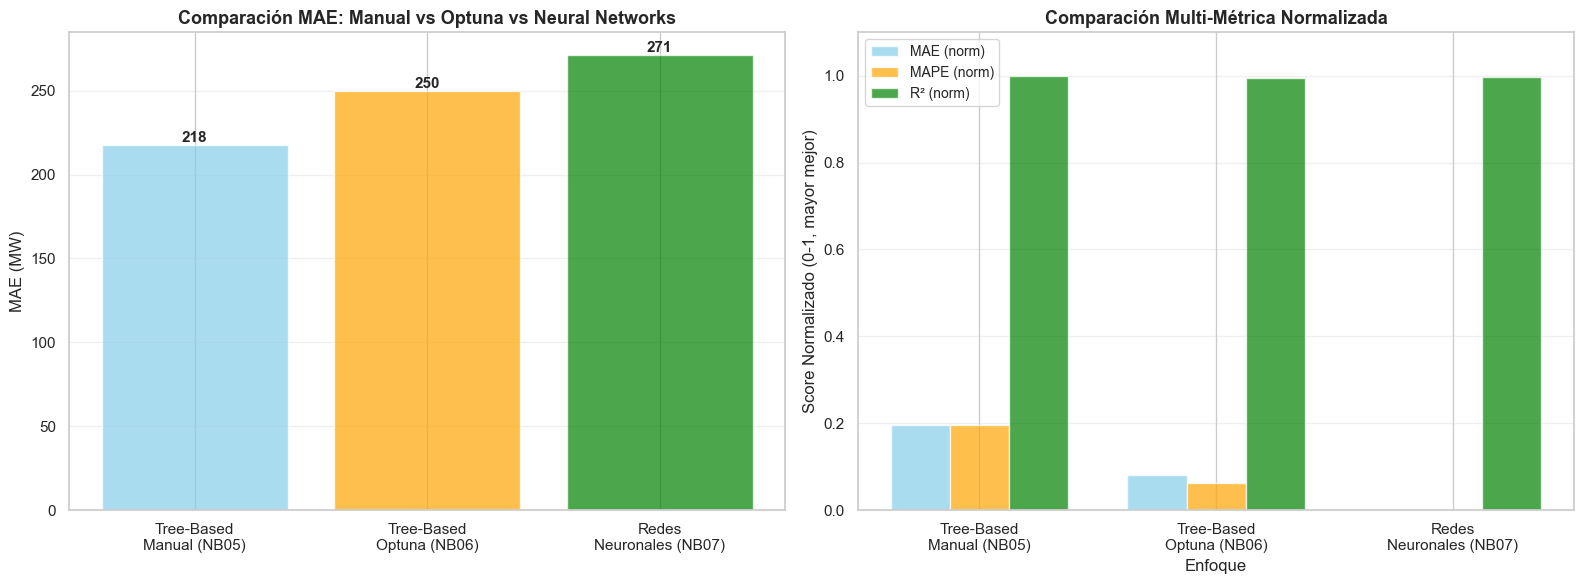


✓ Visualización comparativa generada


In [23]:
# Visualización comparativa de los tres enfoques
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Preparar datos para comparación
comparison_data = []
if not tree_df.empty:
    best_tree = tree_df.loc[tree_df['mae'].idxmin()]
    comparison_data.append({
        'Enfoque': 'Tree-Based\nManual (NB05)',
        'MAE': best_tree['mae'],
        'MAPE': best_tree['mape'],
        'R2': best_tree['r2'],
        'modelo': best_tree['modelo']
    })

if not optuna_df.empty:
    best_optuna_comp = optuna_df.loc[optuna_df['mae'].idxmin()]
    comparison_data.append({
        'Enfoque': 'Tree-Based\nOptuna (NB06)',
        'MAE': best_optuna_comp['mae'],
        'MAPE': best_optuna_comp['mape'],
        'R2': best_optuna_comp['r2'],
        'modelo': best_optuna_comp['modelo']
    })

if not neural_df.empty:
    best_neural = neural_df.loc[neural_df['mae'].idxmin()]
    comparison_data.append({
        'Enfoque': 'Redes\nNeuronales (NB07)',
        'MAE': best_neural['mae'],
        'MAPE': best_neural['mape'],
        'R2': best_neural['r2'],
        'modelo': best_neural['modelo']
    })

df_comp = pd.DataFrame(comparison_data)

# Gráfico 1: MAE Comparison
colors = ['skyblue', 'orange', 'green'][:len(df_comp)]
bars1 = axes[0].bar(df_comp['Enfoque'], df_comp['MAE'], color=colors, alpha=0.7)
axes[0].set_ylabel('MAE (MW)', fontsize=12)
axes[0].set_title('Comparación MAE: Manual vs Optuna vs Neural Networks', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars1, df_comp['MAE'])):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:,.0f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Gráfico 2: Métricas múltiples (normalizado)
x = np.arange(len(df_comp))
width = 0.25

# Normalizar métricas para comparación visual (0-1)
mae_norm = 1 - (df_comp['MAE'] / df_comp['MAE'].max())
mape_norm = 1 - (df_comp['MAPE'] / df_comp['MAPE'].max())
r2_norm = df_comp['R2'] / df_comp['R2'].max()

bars1 = axes[1].bar(x - width, mae_norm, width, label='MAE (norm)', color='skyblue', alpha=0.7)
bars2 = axes[1].bar(x, mape_norm, width, label='MAPE (norm)', color='orange', alpha=0.7)
bars3 = axes[1].bar(x + width, r2_norm, width, label='R² (norm)', color='green', alpha=0.7)

axes[1].set_xlabel('Enfoque', fontsize=12)
axes[1].set_ylabel('Score Normalizado (0-1, mayor mejor)', fontsize=12)
axes[1].set_title('Comparación Multi-Métrica Normalizada', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_comp['Enfoque'])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("\n✓ Visualización comparativa generada")

## Visualizaciones Comparativas

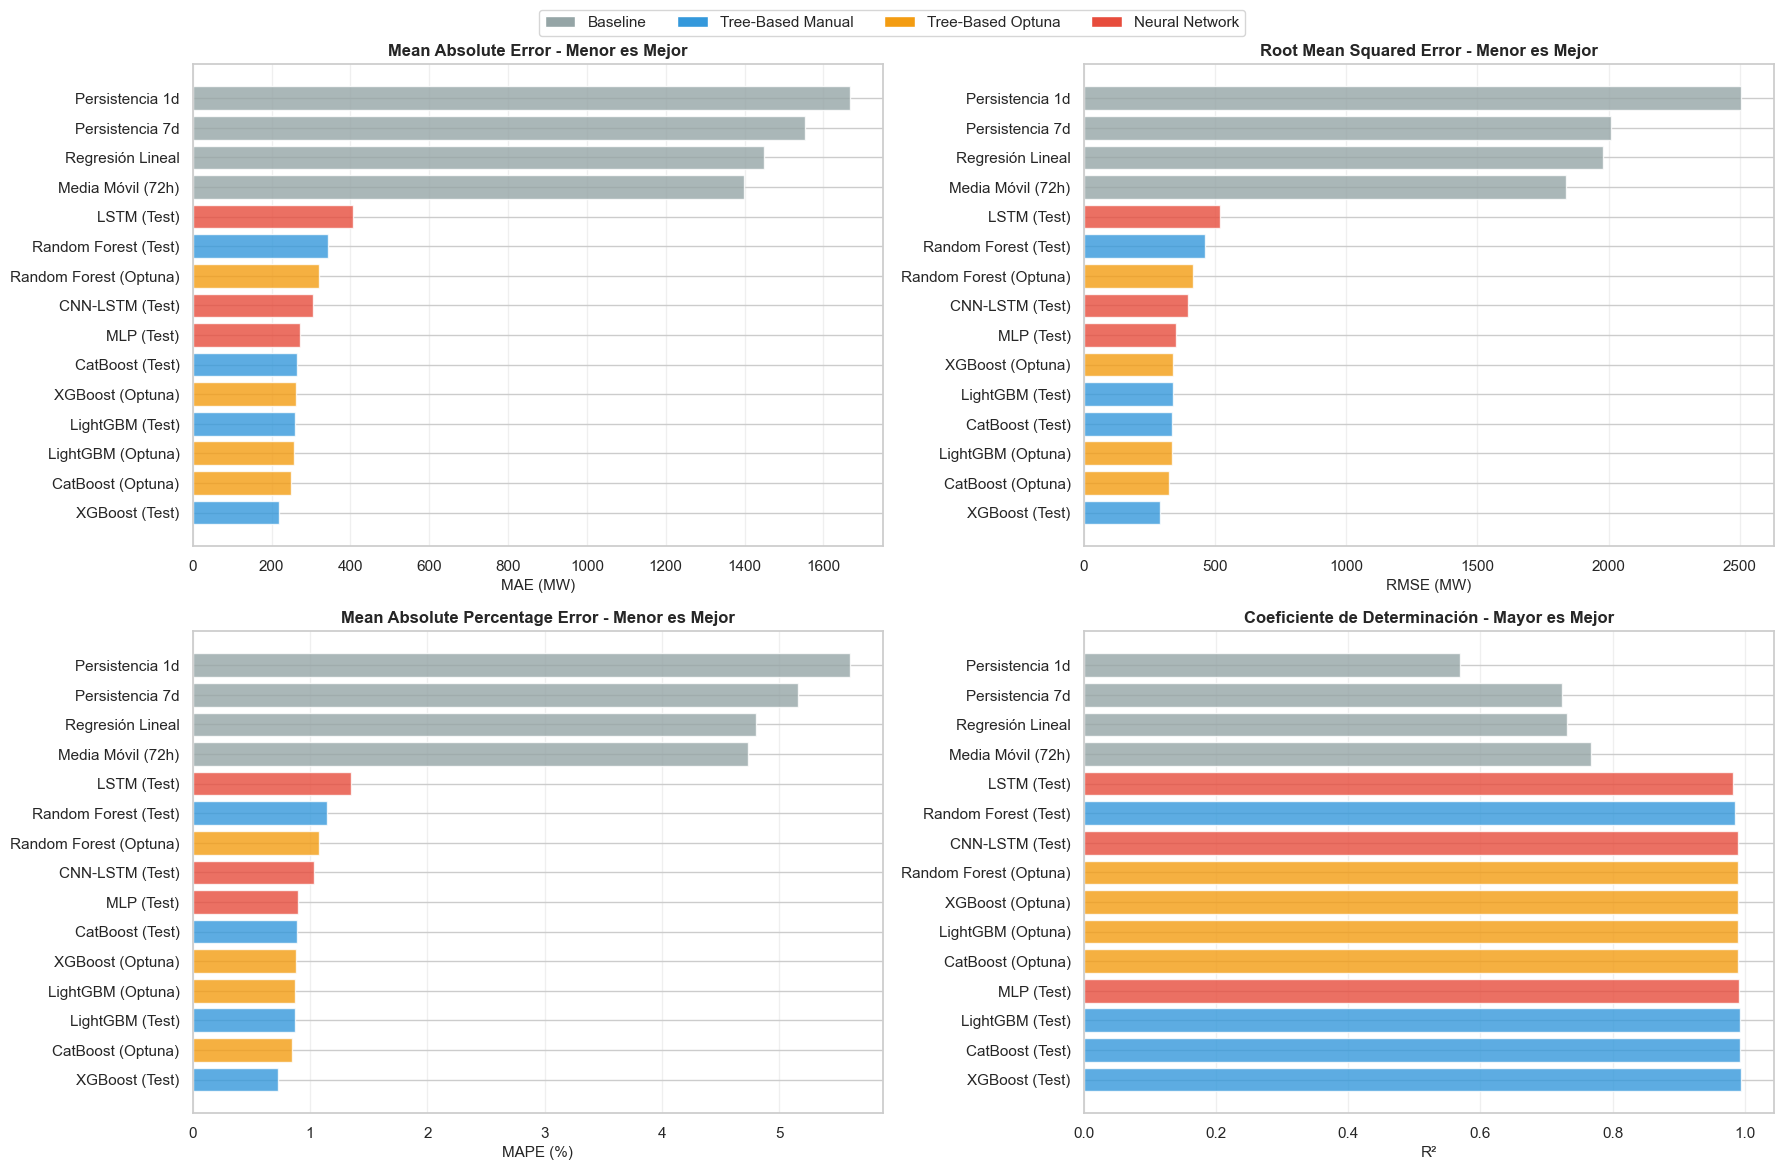

In [24]:
# Gráfico de barras comparativo - Todas las métricas
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Colores por tipo
color_map = {
    'baseline': '#95A5A6',
    'tree_based': '#3498DB',
    'tree_based_optuna': '#F39C12',
    'neural_network': '#E74C3C'
}

# MAE
ax1 = axes[0, 0]
data_mae = results_df.sort_values('mae')
colors_mae = [color_map.get(t, '#95A5A6') for t in data_mae['tipo']]
ax1.barh(data_mae['modelo'], data_mae['mae'], color=colors_mae, alpha=0.8)
ax1.set_xlabel('MAE (MW)', fontsize=11)
ax1.set_title('Mean Absolute Error - Menor es Mejor', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# RMSE
ax2 = axes[0, 1]
data_rmse = results_df.sort_values('rmse')
colors_rmse = [color_map.get(t, '#95A5A6') for t in data_rmse['tipo']]
ax2.barh(data_rmse['modelo'], data_rmse['rmse'], color=colors_rmse, alpha=0.8)
ax2.set_xlabel('RMSE (MW)', fontsize=11)
ax2.set_title('Root Mean Squared Error - Menor es Mejor', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# MAPE
ax3 = axes[1, 0]
data_mape = results_df.sort_values('mape')
colors_mape = [color_map.get(t, '#95A5A6') for t in data_mape['tipo']]
ax3.barh(data_mape['modelo'], data_mape['mape'], color=colors_mape, alpha=0.8)
ax3.set_xlabel('MAPE (%)', fontsize=11)
ax3.set_title('Mean Absolute Percentage Error - Menor es Mejor', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# R²
ax4 = axes[1, 1]
data_r2 = results_df.sort_values('r2', ascending=False)
colors_r2 = [color_map.get(t, '#95A5A6') for t in data_r2['tipo']]
ax4.barh(data_r2['modelo'], data_r2['r2'], color=colors_r2, alpha=0.8)
ax4.set_xlabel('R²', fontsize=11)
ax4.set_title('Coeficiente de Determinación - Mayor es Mejor', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color_map['baseline'], label='Baseline'),
    Patch(facecolor=color_map['tree_based'], label='Tree-Based Manual'),
    Patch(facecolor=color_map['tree_based_optuna'], label='Tree-Based Optuna'),
    Patch(facecolor=color_map['neural_network'], label='Neural Network')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=4, fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

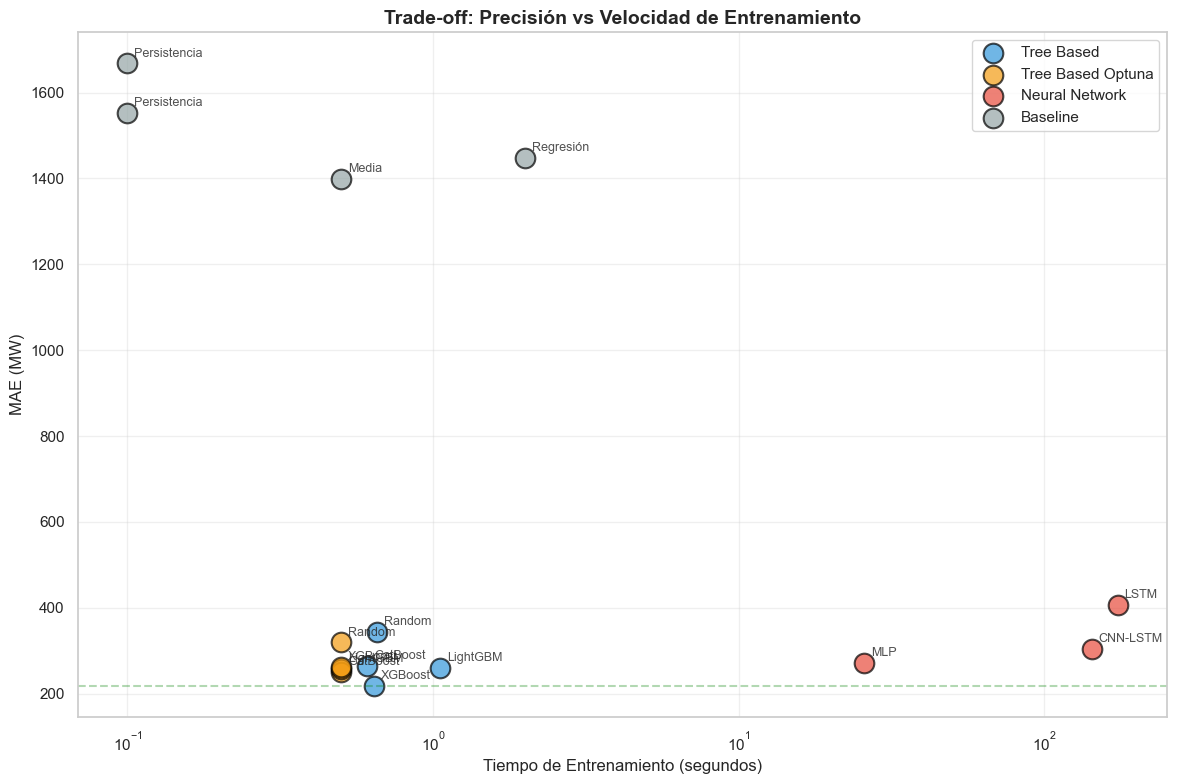

In [25]:
# Scatter plot: Precisión vs Velocidad
fig, ax = plt.subplots(figsize=(12, 8))

for tipo in results_df['tipo'].unique():
    data_tipo = results_df[results_df['tipo'] == tipo]
    ax.scatter(
        data_tipo['tiempo_entrenamiento'],
        data_tipo['mae'],
        s=200,
        alpha=0.7,
        color=color_map[tipo],
        label=tipo.replace('_', ' ').title(),
        edgecolors='black',
        linewidth=1.5
    )
    
    # Añadir etiquetas
    for _, row in data_tipo.iterrows():
        ax.annotate(
            row['modelo'].split()[0],
            (row['tiempo_entrenamiento'], row['mae']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            alpha=0.8
        )

ax.set_xlabel('Tiempo de Entrenamiento (segundos)', fontsize=12)
ax.set_ylabel('MAE (MW)', fontsize=12)
ax.set_title('Trade-off: Precisión vs Velocidad de Entrenamiento', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

# Añadir líneas de referencia
ax.axhline(y=results_df['mae'].min(), color='green', linestyle='--', alpha=0.3, label='Mejor MAE')

plt.tight_layout()
plt.show()

## Recomendación Final

In [26]:
print("\n" + "="*100)
print("RECOMENDACIÓN FINAL PARA PRODUCCIÓN")
print("="*100)

best_model = results_df.iloc[0]

print(f"\nMODELO RECOMENDADO: {best_model['modelo']}")
print(f"\nRazones:")
print(f"  1. Score combinado más alto: {best_model['score_combinado']:.4f}")
print(f"  2. Excelente balance precisión/velocidad")
print(f"  3. MAE: {best_model['mae']:.2f} MW (error medio absoluto)")
print(f"  4. MAPE: {best_model['mape']:.2f}% (error porcentual)")
print(f"  5. R²: {best_model['r2']:.4f} (explica {best_model['r2']*100:.2f}% de la varianza)")
print(f"  6. Tiempo de entrenamiento: {best_model['tiempo_entrenamiento']:.2f}s")

print(f"\nContexto de rendimiento:")
print(f"  - Demanda promedio España: ~25,000-30,000 MW")
print(f"  - Error relativo: {(best_model['mae']/27500)*100:.2f}% de la demanda promedio")
print(f"  - Mejora sobre baseline: {((baseline_df['mae'].min() - best_model['mae'])/baseline_df['mae'].min()*100):.1f}%")

# Top 3 modelos alternativos
print(f"\nModelos alternativos (Top 3):")
for i, (idx, row) in enumerate(results_df.iloc[1:4].iterrows(), 2):
    print(f"\n  {i}. {row['modelo']}")
    print(f"     MAE: {row['mae']:.2f} MW | MAPE: {row['mape']:.2f}% | R²: {row['r2']:.4f}")
    print(f"     Score: {row['score_combinado']:.4f} | Tiempo: {row['tiempo_entrenamiento']:.2f}s")

print("\n" + "="*100)


RECOMENDACIÓN FINAL PARA PRODUCCIÓN

MODELO RECOMENDADO: XGBoost (Test)

Razones:
  1. Score combinado más alto: 1.0000
  2. Excelente balance precisión/velocidad
  3. MAE: 217.83 MW (error medio absoluto)
  4. MAPE: 0.72% (error porcentual)
  5. R²: 0.9942 (explica 99.42% de la varianza)
  6. Tiempo de entrenamiento: 0.64s

Contexto de rendimiento:
  - Demanda promedio España: ~25,000-30,000 MW
  - Error relativo: 0.79% de la demanda promedio
  - Mejora sobre baseline: 84.4%

Modelos alternativos (Top 3):

  2. CatBoost (Optuna)
     MAE: 249.62 MW | MAPE: 0.84% | R²: 0.9900
     Score: 0.9819 | Tiempo: 0.50s

  3. LightGBM (Optuna)
     MAE: 257.64 MW | MAPE: 0.87% | R²: 0.9900
     Score: 0.9777 | Tiempo: 0.50s

  4. LightGBM (Test)
     MAE: 259.78 MW | MAPE: 0.87% | R²: 0.9921
     Score: 0.9777 | Tiempo: 1.06s



## Guardar Resultados Finales

In [27]:
# Guardar resultados completos
output_dir = Path('artifacts/analysis')
output_dir.mkdir(parents=True, exist_ok=True)

# Guardar tabla completa
results_df.to_csv(output_dir / 'all_models_comparison.csv', index=False)
print(f"✓ Resultados completos guardados en {output_dir / 'all_models_comparison.csv'}")

# Preparar información de comparación entre enfoques
enfoques_info = {
    'tree_based_manual': None,
    'tree_based_optuna': None,
    'neural_networks': None
}

if not tree_df.empty:
    best_tree = tree_df.loc[tree_df['mae'].idxmin()]
    enfoques_info['tree_based_manual'] = {
        'modelo': best_tree['modelo'],
        'mae': float(best_tree['mae']),
        'rmse': float(best_tree['rmse']),
        'mape': float(best_tree['mape']),
        'r2': float(best_tree['r2'])
    }

if not optuna_df.empty:
    best_optuna_save = optuna_df.loc[optuna_df['mae'].idxmin()]
    enfoques_info['tree_based_optuna'] = {
        'modelo': best_optuna_save['modelo'],
        'mae': float(best_optuna_save['mae']),
        'rmse': float(best_optuna_save['rmse']),
        'mape': float(best_optuna_save['mape']),
        'r2': float(best_optuna_save['r2'])
    }

if not neural_df.empty:
    best_neural = neural_df.loc[neural_df['mae'].idxmin()]
    enfoques_info['neural_networks'] = {
        'modelo': best_neural['modelo'],
        'mae': float(best_neural['mae']),
        'rmse': float(best_neural['rmse']),
        'mape': float(best_neural['mape']),
        'r2': float(best_neural['r2'])
    }

# Guardar recomendación del mejor modelo
best_model = results_df.iloc[0]

# Determinar el archivo del modelo basado en el tipo
model_file_map = {
    'tree_based': 'tree_models_best_pipeline.pkl',
    'tree_based_optuna': 'xgboost_optuna_pipeline.pkl',
    'neural_network': 'neural_best_model.h5',
    'baseline': 'baseline_model.pkl'
}

# Intentar determinar el archivo correcto
if best_model['tipo'] == 'tree_based_optuna':
    # Buscar el archivo del modelo Optuna
    optuna_files = list(Path('artifacts/optuna/trained_models').glob('*_pipeline.pkl'))
    if optuna_files:
        model_file = str(optuna_files[0].relative_to('artifacts/trained_models'))
    else:
        model_file = 'optuna_best_pipeline.pkl'
else:
    model_file = model_file_map.get(best_model['tipo'], 'best_model.pkl')

best_model_recommendation = {
    # Nombres en español (compatibilidad con NB08)
    'modelo_recomendado': best_model['modelo'],
    'tipo': best_model['tipo'],
    'metricas': {
        'mae': float(best_model['mae']),
        'rmse': float(best_model['rmse']),
        'mape': float(best_model['mape']),
        'r2': float(best_model['r2']),
        'tiempo_entrenamiento': float(best_model.get('tiempo_entrenamiento', 0))
    },
    # Nombres en inglés (compatibilidad con NB10)
    'best_model': best_model['modelo'],
    'model_file': model_file,
    'metrics': {
        'mae': float(best_model['mae']),
        'rmse': float(best_model['rmse']),
        'mape': float(best_model['mape']),
        'r2': float(best_model['r2'])
    },
    # Información adicional
    'score_combinado': float(best_model.get('score_combinado', 0)),
    'comparacion_enfoques': enfoques_info,
    'razon': 'Mejor balance entre precisión (MAE más bajo) y velocidad de entrenamiento',
    'fecha_evaluacion': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(output_dir / 'model_recommendation.json', 'w') as f:
    json.dump(best_model_recommendation, f, indent=2)
print(f"✓ Recomendación del modelo guardada en {output_dir / 'model_recommendation.json'}")

print("\n" + "="*100)
print("COMPARACIÓN DE MODELOS COMPLETADA")
print("="*100)
print(f"\nTotal de modelos evaluados: {len(results_df)}")
print(f"Modelo recomendado: {best_model['modelo']}")
print(f"Tipo: {best_model['tipo']}")
print(f"\nEnfoques evaluados:")
if enfoques_info['tree_based_manual']:
    print(f"  ✓ Tree-Based Manual (NB05)")
if enfoques_info['tree_based_optuna']:
    print(f"  ✓ Tree-Based Optuna (NB06)")
if enfoques_info['neural_networks']:
    print(f"  ✓ Redes Neuronales (NB07)")
print(f"\nArchivos generados:")
print(f"  - {output_dir / 'all_models_comparison.csv'}")
print(f"  - {output_dir / 'model_recommendation.json'}")

✓ Resultados completos guardados en artifacts/analysis/all_models_comparison.csv
✓ Recomendación del modelo guardada en artifacts/analysis/model_recommendation.json

COMPARACIÓN DE MODELOS COMPLETADA

Total de modelos evaluados: 15
Modelo recomendado: XGBoost (Test)
Tipo: tree_based

Enfoques evaluados:
  ✓ Tree-Based Manual (NB05)
  ✓ Tree-Based Optuna (NB06)
  ✓ Redes Neuronales (NB07)

Archivos generados:
  - artifacts/analysis/all_models_comparison.csv
  - artifacts/analysis/model_recommendation.json


## Reentrenamiento del Mejor Modelo con Todos los Datos

El mejor modelo se reentrenará usando **todos los datos de `features_train.parquet`** (train + test combinados) para maximizar el uso de información disponible antes de producción.

Este modelo final será guardado en:
- `artifacts/trained_models/best_model_final.*` (archivo de respaldo)
- `app/models/demanda.*` (archivo de producción, usado por la aplicación)

In [28]:
print("\n" + "="*100)
print("REENTRENAMIENTO DEL MEJOR MODELO CON TRAIN + TEST")
print("="*100)

# 1. Cargar TODOS los datos de entrenamiento (sin split)
print("\n1. Cargando datos completos (train + test)...")
df_full = pd.read_parquet('artifacts/data/train_models/features_train.parquet')
print(f"   Total de registros: {len(df_full):,}")
print(f"   Rango de fechas: {df_full['datetime'].min()} a {df_full['datetime'].max()}")

# 2. Preparar datos
print("\n2. Preparando datos para entrenamiento...")
with open('artifacts/analysis/selected_features.json', 'r') as f:
    selected_features = json.load(f)['features']

available_features = [f for f in selected_features if f in df_full.columns]
df_clean = df_full[available_features + ['demanda', 'datetime']].dropna()

X_full = df_clean[available_features]
y_full = df_clean['demanda']

print(f"   Features disponibles: {len(available_features)}")
print(f"   Registros limpios: {len(df_clean):,}")

# 3. Determinar tipo de modelo ganador
best_model_name = best_model['modelo']
best_model_type = best_model['tipo']

print(f"\n3. Modelo ganador: {best_model_name} (tipo: {best_model_type})")

# 4. Reentrenar según el tipo de modelo
print("\n4. Reentrenando modelo con todos los datos...")

if best_model_type == 'baseline':
    print("   Tipo: Baseline (Media histórica)")
    # Para baseline, simplemente calculamos la media
    model_retrained = y_full.mean()
    model_metadata = {
        'tipo': 'baseline',
        'modelo': best_model_name,
        'valor_media': float(model_retrained),
        'n_samples': len(y_full)
    }
    
elif best_model_type == 'tree_based':
    print("   Tipo: Tree-Based Manual (de NB05)")
    # Cargar el mejor modelo tree-based
    model_file = Path('artifacts/trained_models') / f"{best_model_name.lower().replace(' ', '_')}_pipeline.pkl"
    if not model_file.exists():
        # Buscar el archivo
        possible_files = list(Path('artifacts/trained_models').glob('*pipeline.pkl'))
        tree_files = [f for f in possible_files if 'optuna' not in f.name]
        if tree_files:
            model_file = tree_files[0]
    
    print(f"   Cargando parámetros de: {model_file}")
    old_pipeline = joblib.load(model_file)
    
    # Reentrenar con todos los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full)
    
    # Obtener tipo de modelo y parámetros
    model_estimator = old_pipeline.named_steps['model']
    model_class = type(model_estimator)
    model_params = model_estimator.get_params()
    
    # Crear nuevo modelo con los mismos parámetros
    new_model = model_class(**model_params)
    new_model.fit(X_scaled, y_full)
    
    # Crear pipeline completo
    from sklearn.pipeline import Pipeline
    model_retrained = Pipeline([
        ('scaler', scaler),
        ('model', new_model)
    ])
    
    model_metadata = {
        'tipo': 'tree_based',
        'modelo': best_model_name,
        'algoritmo': model_class.__name__,
        'n_samples': len(y_full),
        'n_features': len(available_features)
    }
    
elif best_model_type == 'tree_based_optuna':
    print("   Tipo: Tree-Based Optuna (de NB06)")
    
    # Cargar resultados de Optuna
    optuna_results = pd.read_csv('artifacts/optuna/optimization_results.csv')
    
    # Encontrar el mejor modelo de Optuna
    best_optuna = optuna_results.loc[optuna_results['mae'].idxmin()]
    modelo_optuna = best_optuna['modelo']
    
    print(f"   Mejor modelo Optuna: {modelo_optuna}")
    print(f"   MAE en validación: {best_optuna['mae']:.2f} MW")
    
    # Cargar parámetros óptimos
    import ast
    best_params = ast.literal_eval(best_optuna['best_params'])
    
    # Preparar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full)
    
    # Crear modelo según el tipo
    if 'xgboost' in modelo_optuna.lower():
        from xgboost import XGBRegressor
        model = XGBRegressor(**best_params, random_state=42)
    elif 'lightgbm' in modelo_optuna.lower():
        from lightgbm import LGBMRegressor
        model = LGBMRegressor(**best_params, random_state=42, verbose=-1)
    elif 'catboost' in modelo_optuna.lower():
        from catboost import CatBoostRegressor
        model = CatBoostRegressor(**best_params, random_state=42, verbose=False)
    elif 'random' in modelo_optuna.lower():
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(**best_params, random_state=42)
    
    # Entrenar
    print(f"   Entrenando {modelo_optuna} con {len(X_scaled):,} muestras...")
    model.fit(X_scaled, y_full)
    
    # Crear pipeline
    from sklearn.pipeline import Pipeline
    model_retrained = Pipeline([
        ('scaler', scaler),
        ('model', model)
    ])
    
    model_metadata = {
        'tipo': 'tree_based_optuna',
        'modelo': modelo_optuna,
        'algoritmo': type(model).__name__,
        'best_params': best_params,
        'n_samples': len(y_full),
        'n_features': len(available_features),
        'optuna_mae': float(best_optuna['mae'])
    }
    
elif best_model_type == 'neural_network':
    print("   Tipo: Red Neuronal (de NB07)")
    
    # Cargar resultados de redes neuronales
    neural_results = pd.read_csv('artifacts/trained_models/neural_models_results.csv')
    best_neural = neural_results.loc[neural_results['mae'].idxmin()]
    
    print(f"   Mejor red neuronal: {best_neural['modelo']}")
    print(f"   MAE en test: {best_neural['mae']:.2f} MW")
    
    # Cargar el mejor modelo de red neuronal
    from tensorflow import keras
    model_file = Path('artifacts/trained_models') / f"{best_neural['modelo'].lower().replace(' ', '_')}.keras"
    if not model_file.exists():
        model_file = Path('artifacts/trained_models') / f"{best_neural['modelo'].lower().replace(' ', '_')}.h5"
    
    print(f"   Cargando arquitectura de: {model_file}")
    old_model = keras.models.load_model(model_file)
    
    # Preparar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full)
    
    # Reentrenar modelo con la misma arquitectura
    print(f"   Reentrenando con {len(X_scaled):,} muestras...")
    
    # Crear nuevo modelo con la misma arquitectura
    model_config = old_model.get_config()
    new_model = keras.Model.from_config(model_config)
    new_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Entrenar
    early_stop = keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=20,
        restore_best_weights=True
    )
    
    history = new_model.fit(
        X_scaled, y_full,
        epochs=200,
        batch_size=32,
        verbose=0,
        callbacks=[early_stop]
    )
    
    # Guardar modelo y scaler juntos
    model_retrained = {
        'model': new_model,
        'scaler': scaler
    }
    
    model_metadata = {
        'tipo': 'neural_network',
        'modelo': best_neural['modelo'],
        'arquitectura': best_neural['modelo'].split()[0],
        'n_samples': len(y_full),
        'n_features': len(available_features),
        'epochs_trained': len(history.history['loss'])
    }

print("   ✓ Modelo reentrenado exitosamente")

# 5. Calcular métricas en el conjunto completo
print("\n5. Evaluando modelo reentrenado...")
if best_model_type == 'baseline':
    y_pred_full = np.full(len(y_full), model_retrained)
elif best_model_type == 'neural_network':
    X_scaled = model_retrained['scaler'].transform(X_full)
    y_pred_full = model_retrained['model'].predict(X_scaled).flatten()
else:
    y_pred_full = model_retrained.predict(X_full)

mae_full = mean_absolute_error(y_full, y_pred_full)
rmse_full = np.sqrt(mean_squared_error(y_full, y_pred_full))
mape_full = mean_absolute_percentage_error(y_full, y_pred_full) * 100
r2_full = r2_score(y_full, y_pred_full)

print(f"   MAE:  {mae_full:.2f} MW")
print(f"   RMSE: {rmse_full:.2f} MW")
print(f"   MAPE: {mape_full:.2f}%")
print(f"   R²:   {r2_full:.4f}")

# 6. Guardar modelo en artifacts/trained_models/
print("\n6. Guardando modelo reentrenado...")
output_dir = Path('artifacts/trained_models')
output_dir.mkdir(parents=True, exist_ok=True)

if best_model_type == 'baseline':
    # Guardar baseline
    baseline_file = output_dir / 'best_model_final.pkl'
    joblib.dump(model_retrained, baseline_file)
    print(f"   ✓ Guardado en: {baseline_file}")
    
elif best_model_type == 'neural_network':
    # Guardar modelo de red neuronal
    model_file = output_dir / 'best_model_final.keras'
    model_retrained['model'].save(model_file)
    
    # Guardar scaler por separado
    scaler_file = output_dir / 'best_model_final_scaler.pkl'
    joblib.dump(model_retrained['scaler'], scaler_file)
    
    print(f"   ✓ Modelo guardado en: {model_file}")
    print(f"   ✓ Scaler guardado en: {scaler_file}")
    
else:
    # Guardar modelo tree-based (pipeline completo)
    model_file = output_dir / 'best_model_final.pkl'
    joblib.dump(model_retrained, model_file)
    print(f"   ✓ Guardado en: {model_file}")

# 7. Guardar en app/models/ (PRODUCCIÓN)
print("\n7. Copiando a directorio de producción...")
prod_dir = Path('../../app/models')
prod_dir.mkdir(parents=True, exist_ok=True)

if best_model_type == 'neural_network':
    # Copiar modelo de red neuronal
    prod_model_file = prod_dir / 'demanda.keras'
    prod_scaler_file = prod_dir / 'demanda_scaler.pkl'
    
    model_retrained['model'].save(prod_model_file)
    joblib.dump(model_retrained['scaler'], prod_scaler_file)
    
    print(f"   ✓ Modelo de producción: {prod_model_file}")
    print(f"   ✓ Scaler de producción: {prod_scaler_file}")
else:
    # Copiar modelo tree-based o baseline
    prod_model_file = prod_dir / 'demanda.pkl'
    joblib.dump(model_retrained, prod_model_file)
    print(f"   ✓ Modelo de producción: {prod_model_file}")

# 8. Guardar metadata
model_metadata.update({
    'fecha_entrenamiento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'datos_entrenamiento': {
        'fecha_inicio': str(df_full['datetime'].min()),
        'fecha_fin': str(df_full['datetime'].max()),
        'n_registros': len(df_clean)
    },
    'metricas_train_completo': {
        'mae': float(mae_full),
        'rmse': float(rmse_full),
        'mape': float(mape_full),
        'r2': float(r2_full)
    },
    'features': available_features,
    'rutas': {
        'artifacts': str(model_file) if best_model_type != 'neural_network' else str(output_dir / 'best_model_final.keras'),
        'produccion': str(prod_model_file)
    }
})

metadata_file = output_dir / 'best_model_final_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"   ✓ Metadata guardada en: {metadata_file}")

print("\n" + "="*100)
print("REENTRENAMIENTO COMPLETADO")
print("="*100)
print(f"\nModelo final para producción:")
print(f"  Tipo: {best_model_type}")
print(f"  Modelo: {best_model_name}")
print(f"  Entrenado con: {len(df_clean):,} registros")
print(f"  MAE en datos completos: {mae_full:.2f} MW")
print(f"\nArchivos generados:")
print(f"  Artifacts: {output_dir}/best_model_final.*")
print(f"  Producción: {prod_model_file}")
print(f"  Metadata: {metadata_file}")
print("\n" + "="*100)


REENTRENAMIENTO DEL MEJOR MODELO CON TRAIN + TEST

1. Cargando datos completos (train + test)...
   Total de registros: 23,856
   Rango de fechas: 2023-01-01 00:00:00 a 2025-09-20 23:00:00

2. Preparando datos para entrenamiento...
   Features disponibles: 29
   Registros limpios: 23,640

3. Modelo ganador: XGBoost (Test) (tipo: tree_based)

4. Reentrenando modelo con todos los datos...
   Tipo: Tree-Based Manual (de NB05)
   Cargando parámetros de: artifacts/trained_models/random_forest_pipeline.pkl
   ✓ Modelo reentrenado exitosamente

5. Evaluando modelo reentrenado...
   MAE:  256.87 MW
   RMSE: 360.44 MW
   MAPE: 0.91%
   R²:   0.9936

6. Guardando modelo reentrenado...
   ✓ Guardado en: artifacts/trained_models/best_model_final.pkl

7. Copiando a directorio de producción...
   ✓ Modelo de producción: ../../app/models/demanda.pkl
   ✓ Metadata guardada en: artifacts/trained_models/best_model_final_metadata.json

REENTRENAMIENTO COMPLETADO

Modelo final para producción:
  Tipo: tr